<center>
<h1>Proyecto Final - Coterminal</h1>
</center>

- Carlos Andrés Zuluaga Mora
- Ricardo Andrés Cortés Coronell
- Andrés Felipe Sánchez Rincón

## Requisitos de ejecución

- Cree un entorno Python (Versión 3.11 como mínimo) en su máquina mediante el comando `conda create -n {nombre del entorno}`.
- Instale todas las librerías faltantes con el comando `conda install {nombre de la librería}`. De presentarse el caso en el que dicho comando no funcione adecuadamente, recurra a opciones como `conda-forge` o `pip` para continuar con el proceso de instalación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import logging
import psycopg2


### Montaje del contenedor donde se alojará la base de datos

In [2]:
# Ejecutar un comando de docker compose
result = subprocess.run(
    ["docker", "compose", "up", "-d"],
    capture_output=True,
    text=True
)

# Ver salida
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)
print("Código de salida:", result.returncode)

STDOUT: 
STDERR: time="2025-09-03T10:16:21-05:00" level=warning msg="c:\\ProyectoBigData\\ProyectoBigData\\docker-compose.yml: the attribute `version` is obsolete, it will be ignored, please remove it to avoid potential confusion"
 Network proyectobigdata_default  Creating
 Network proyectobigdata_default  Created
 Container proyectobigdata-postgres-1  Creating
 Container proyectobigdata-postgres-1  Created
 Container proyectobigdata-postgres-1  Starting
 Container proyectobigdata-postgres-1  Started

Código de salida: 0


### Preparación y limpieza de datos

In [3]:
# Extraer información de archivo .csv
df_covid19 = pd.read_csv("estimated-cumulative-excess-deaths-per-100000-people-during-covid-19.csv")

# Limpieza de datos

# Eliminación de columnas no empleadas 
df_covid19.drop(columns=['Cumulative excess deaths per 100,000 people (95% CI, lower bound)', 
        'Cumulative excess deaths per 100,000 people (95% CI, upper bound)'], inplace=True)

# Cambio de nombres de columnas
df_covid19.rename(columns={
    'Entity': 'País',
    'Day': 'Fecha',
    'Cumulative excess deaths per 100,000 people (central estimate)': 'Exceso_Muertes',
    'Total confirmed deaths due to COVID-19 per 100,000 people': 'Muertes_Confirmadas_100k'
}, inplace=True)

# Convertir la columna 'Fecha' a datetime
df_covid19['Fecha'] = pd.to_datetime(df_covid19['Fecha'])

# La columna de muertes confirmadas tiene nulos al inicio. Asumimos que son 0.
df_covid19['Muertes_Confirmadas_100k'].fillna(0, inplace=True)

# Para el análisis, las filas sin una estimación central de exceso de muertes no son útiles.
df_covid19.dropna(subset=['País', 'Fecha', 'Exceso_Muertes'], inplace=True)


df_covid19.info()
df_covid19.head()

<class 'pandas.core.frame.DataFrame'>
Index: 55458 entries, 0 to 509042
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   País                      55458 non-null  object        
 1   Fecha                     55458 non-null  datetime64[ns]
 2   Exceso_Muertes            55458 non-null  float64       
 3   Muertes_Confirmadas_100k  55458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.1+ MB


C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\4277307290.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_covid19['Muertes_Confirmadas_100k'].fillna(0, inplace=True)


,País,Fecha,Exceso_Muertes,Muertes_Confirmadas_100k
0,Afghanistan,2020-01-01,-0.022148,0.0
1,Afghanistan,2020-01-06,-0.044295,0.0
2,Afghanistan,2020-01-13,-0.047579,0.0
3,Afghanistan,2020-01-20,0.022123,0.0
4,Afghanistan,2020-01-27,0.063374,0.0


### Creación de DB y cargue de información

In [4]:
import psycopg2

# === 1. Verificar/crear la base de datos ===
try:
    # Conexión a la base por defecto
    default_conn = psycopg2.connect(
        dbname="postgres",   # Base inicial por defecto
        user="psqluser",
        password="psqlpass",
        host="localhost",
        port="5433"
    )
    default_conn.autocommit = True  # Necesario para CREATE DATABASE

    with default_conn.cursor() as cur:
        cur.execute("SELECT 1 FROM pg_database WHERE datname = %s", ('covid19-project',))
        exists = cur.fetchone()
        if not exists:
            cur.execute('CREATE DATABASE "covid19-project";')
            print("Base de datos 'covid19-project' creada exitosamente.")
        else:
            print("La base de datos 'covid19-project' ya existe.")

except Exception as e:
    print(f"Error al crear la base de datos: {e}")
    raise

finally:
    if 'default_conn' in locals():
        default_conn.close()

# === 2. Conexión a la base 'covid19-project' ===
db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

try:
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()

    # === 3. Crear la tabla ===
    cursor.execute("DROP TABLE IF EXISTS muertes_covid19;")
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS muertes_covid19 (
            id SERIAL PRIMARY KEY,
            pais VARCHAR(100),
            fecha DATE,
            exceso_muertes INT,
            muertes_confirmadas INT
        )
    """)
    conn.commit()
    print("Tabla creada exitosamente.")

    # === 4. Preparar e insertar los datos desde tu DataFrame ===
    data = list(df_covid19[['País', 'Fecha', 'Exceso_Muertes', 'Muertes_Confirmadas_100k']].itertuples(index=False, name=None))

    cursor.executemany("""
        INSERT INTO muertes_covid19 (pais, fecha, exceso_muertes, muertes_confirmadas)
        VALUES (%s, %s, %s, %s)
    """, data)
    conn.commit()
    print(f"{len(data)} filas insertadas exitosamente en la tabla.")

except Exception as e:
    print(f"Error al insertar datos: {e}")
    raise

finally:
    if 'conn' in locals():
        conn.close()

La base de datos 'covid19-project' ya existe.
Tabla creada exitosamente.
55458 filas insertadas exitosamente en la tabla.


<center>
<h1>Sección de Análisis</h1>
</center>


### ¿Cómo evolucionaron las muertes confirmadas por COVID-19 a lo largo del tiempo en los 10 países más afectados?
Los resultados muestra la evolución de muertes confirmadas por COVID-19 de los 10 paises mas afectados por la pandemia. El análisis revela que países de Europa del Este y los Balcanes dominan la lista, lo que indica que estas regiones fueron de las más afectadas por la crisis sanitaria.

11:26:20.468 | INFO    | Flow run 'marvellous-sturgeon' - Beginning flow run 'marvellous-sturgeon' for flow 'analyze-excess-deaths-flow'

C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\23244089.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


11:26:20.582 | INFO    | Task run 'extract_from_db-5ff' - Finished in state Completed()

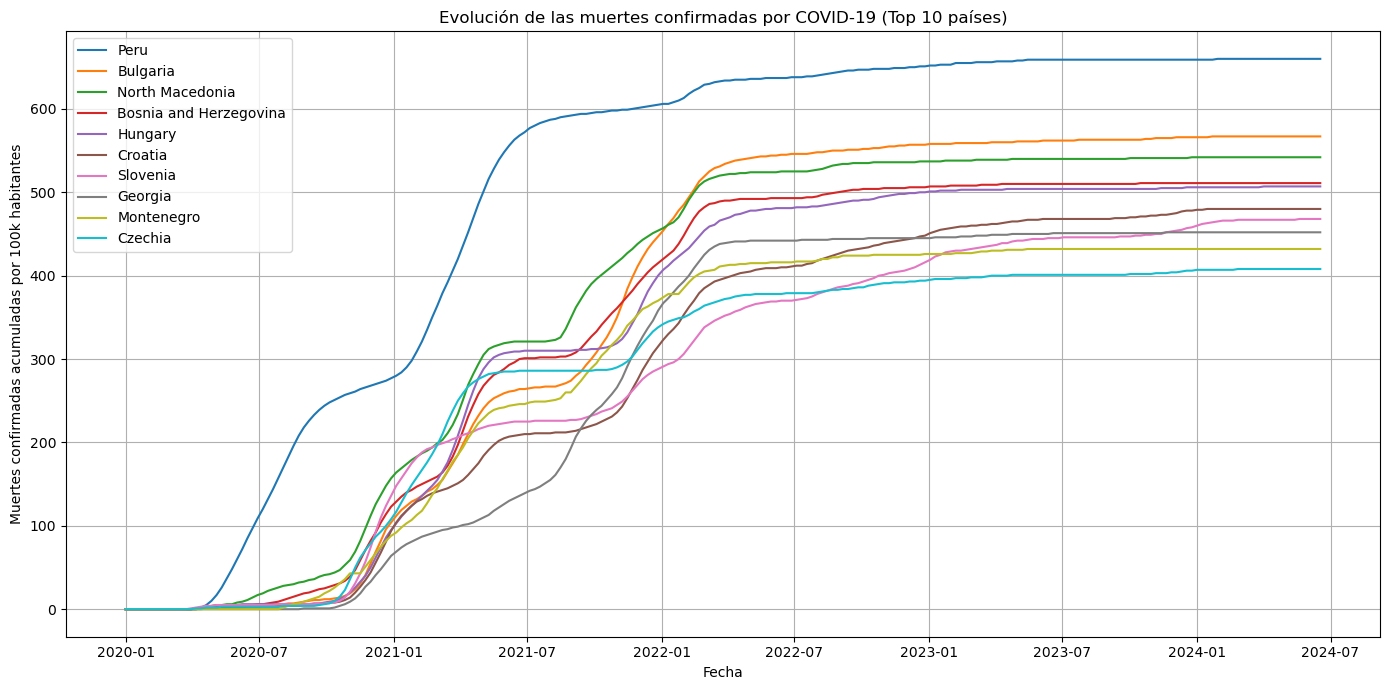

11:26:21.098 | INFO    | Task run 'plot_excess_deaths-529' - Finished in state Completed()

11:26:21.125 | INFO    | Flow run 'marvellous-sturgeon' - Finished in state Completed()

In [33]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT "pais", "fecha", "muertes_confirmadas"
            FROM {table_name}
            WHERE "muertes_confirmadas" IS NOT NULL;
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def plot_excess_deaths(df):
    # Asegurarse de que la columna fecha es datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Graficar todos los países (solo los principales para evitar saturación visual)
    top_countries = df.groupby('pais')['muertes_confirmadas'].max().sort_values(ascending=False).head(10).index
    plt.figure(figsize=(14, 7))
    for country in top_countries:
        country_data = df[df['pais'] == country]
        plt.plot(country_data['fecha'], country_data['muertes_confirmadas'], label=country)

    plt.title("Evolución de las muertes confirmadas por COVID-19 (Top 10 países)")
    plt.xlabel("Fecha")
    plt.ylabel("Muertes confirmadas acumuladas por 100k habitantes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

@flow
def analyze_excess_deaths_flow():
    df = extract_from_db(db_params)
    plot_excess_deaths(df)

# Ejecutar el flow
analyze_excess_deaths_flow()

### ¿Cuál fue el comportamiento de Colombia a nivel de muertes confirmadas y muertes en exceso durante el periodo evaluado?
El comportamiento del exceso de muertes en Colombia siguió muy de cerca a las muertes confirmadas, lo que confirma que las cifras oficiales son un buen indicador de las tendencias de la pandemia, a pesar de un evidente subregistro.

10:45:43.456 | INFO    | Flow run 'astonishing-dove' - Beginning flow run 'astonishing-dove' for flow 'analyze-excess-deaths-flow'

C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\1779561604.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


10:45:43.504 | INFO    | Task run 'extract_from_db-f11' - Finished in state Completed()

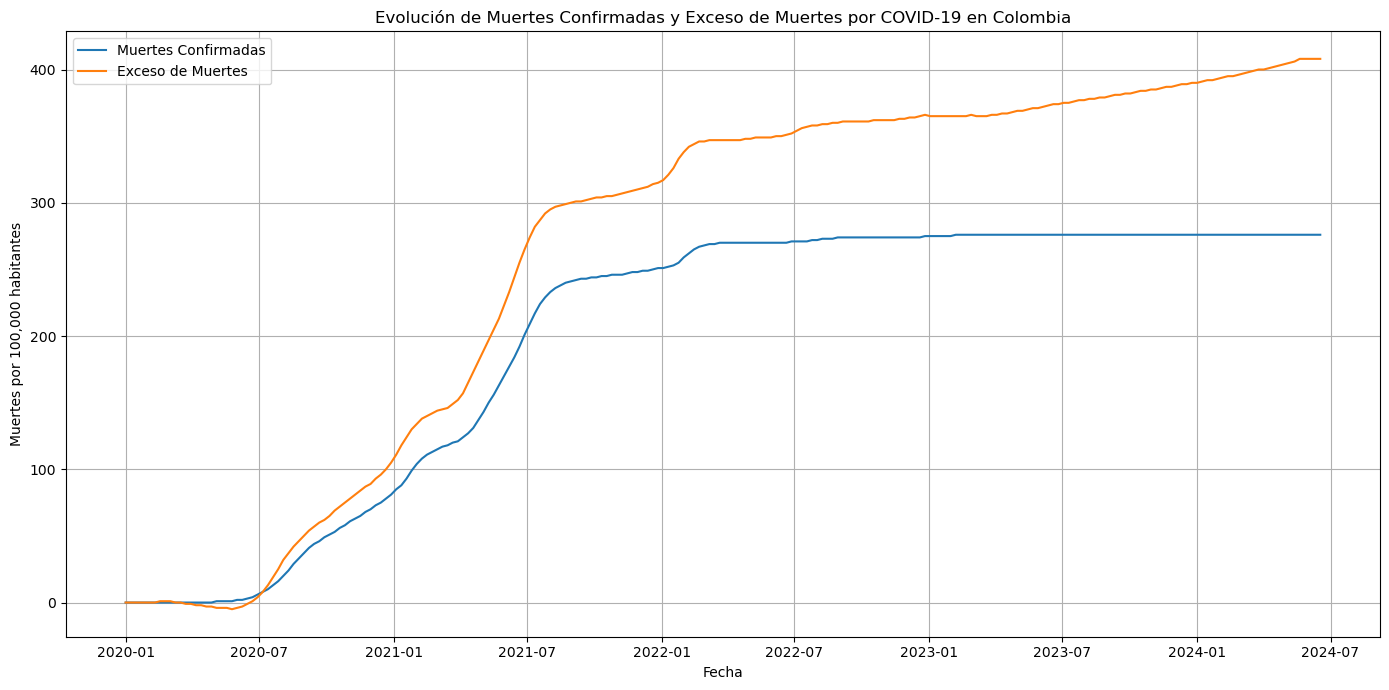

10:45:43.784 | INFO    | Task run 'plot_COLOMBIA_excessANDconfirmed_deaths-ac1' - Finished in state Completed()

10:45:43.816 | INFO    | Flow run 'astonishing-dove' - Finished in state Completed()

In [20]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT "pais", "fecha", "muertes_confirmadas", "exceso_muertes"
            FROM {table_name}
            WHERE "muertes_confirmadas" IS NOT NULL AND "pais" = 'Colombia';
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def plot_COLOMBIA_excessANDconfirmed_deaths(df):
    # Asegurarse de que la columna fecha es datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    plt.figure(figsize=(14, 7))
    plt.plot(df['fecha'], df['muertes_confirmadas'], label='Muertes Confirmadas')
    plt.plot(df['fecha'], df['exceso_muertes'], label='Exceso de Muertes')
    plt.title('Evolución de Muertes Confirmadas y Exceso de Muertes por COVID-19 en Colombia')
    plt.xlabel('Fecha')
    plt.ylabel('Muertes por 100,000 habitantes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

@flow
def analyze_excess_deaths_flow():
    df = extract_from_db(db_params)
    plot_COLOMBIA_excessANDconfirmed_deaths(df)

# Ejecutar el flow
analyze_excess_deaths_flow()

### Distribución de Países por Muertes Confirmadas de COVID-19

La media de muertes confirmadas es de aproximadamente **124.81**. El análisis de los datos revela que la mayoría de los países se encuentran por debajo de este valor, mientras que un numero reducido de países experimentó una mortalidad bastante superior. Esto refleja un patrón de dispersión de la pandemia, donde algunos países sufrieron un impacto mucho mayor en términos de muertes confirmadas.

11:26:51.782 | INFO    | Flow run 'solid-ladybug' - Beginning flow run 'solid-ladybug' for flow 'analyze-deaths-distribution-flow'

C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\843276084.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


11:26:51.850 | INFO    | Task run 'extract_from_db-cca' - Finished in state Completed()

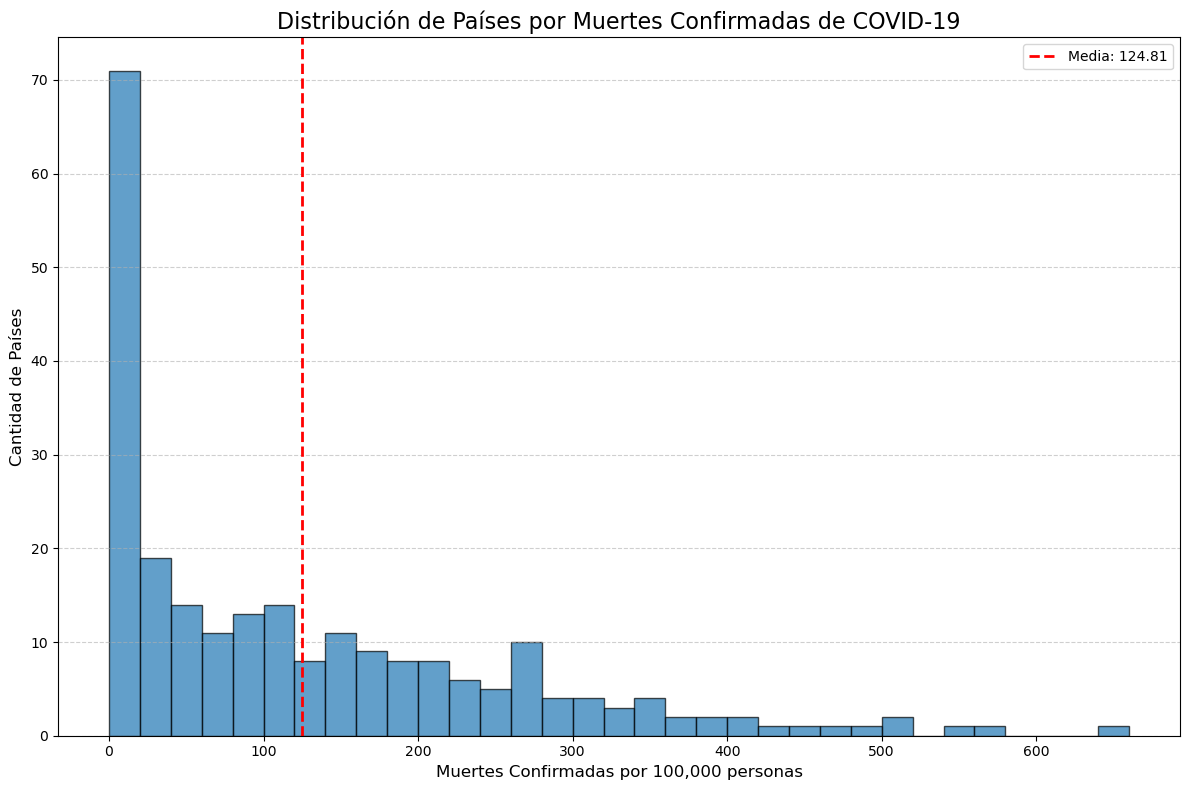

11:26:52.105 | INFO    | Task run 'plot_deaths_histogram-d5d' - Histograma generado correctamente.

11:26:52.110 | INFO    | Task run 'plot_deaths_histogram-d5d' - Finished in state Completed()

11:26:52.131 | INFO    | Task run 'analyze_top_countries-801' - 
Análisis de Países con Mayor Mortalidad Confirmada

11:26:52.134 | INFO    | Task run 'analyze_top_countries-801' - Los 10 países con el mayor número de muertes confirmadas (por 100,000 habitantes) son:

                  pais  muertes_confirmadas
                  Peru                  660
              Bulgaria                  567
       North Macedonia                  542
Bosnia and Herzegovina                  511
               Hungary                  507
               Croatia                  480
              Slovenia                  468
               Georgia                  452
            Montenegro                  432
               Czechia                  408


11:26:52.141 | INFO    | Task run 'analyze_top_countries-801' - Finished in state Completed()

11:26:52.181 | INFO    | Flow run 'solid-ladybug' - Finished in state Completed()

In [34]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT
                "pais",
                MAX("muertes_confirmadas") AS "muertes_confirmadas"
            FROM {table_name}
            GROUP BY "pais"
            ORDER BY "muertes_confirmadas" DESC;
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def plot_deaths_histogram(df):
    logger = get_run_logger()
    if df is None or df.empty:
        logger.warning("No hay datos para graficar.")
        return
        
    df.dropna(subset=['muertes_confirmadas'], inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['muertes_confirmadas'], inplace=True)
    
    bins = np.arange(0, df['muertes_confirmadas'].max() + 20, 20)

    plt.figure(figsize=(12, 8))
    plt.hist(df['muertes_confirmadas'], bins=bins, edgecolor='black', alpha=0.7)
    
    media = df['muertes_confirmadas'].mean()
    plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media:.2f}')
    
    plt.title('Distribución de Países por Muertes Confirmadas de COVID-19', fontsize=16)
    plt.xlabel('Muertes Confirmadas por 100,000 personas', fontsize=12)
    plt.ylabel('Cantidad de Países', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    logger.info("Histograma generado correctamente.")

@task
def analyze_top_countries(df, top_n=10):
    logger = get_run_logger()
    if df is None or df.empty:
        logger.warning("No hay datos para analizar.")
        return

    top_countries = df.sort_values(by='muertes_confirmadas', ascending=False).head(top_n)
    
    logger.info("\nAnálisis de Países con Mayor Mortalidad Confirmada")
    logger.info(f"Los {top_n} países con el mayor número de muertes confirmadas (por 100,000 habitantes) son:")

    print(top_countries.to_string(index=False))

@flow
def analyze_deaths_distribution_flow():
    df = extract_from_db(db_params)
    plot_deaths_histogram(df)
    analyze_top_countries(df)

# Ejecutar el flow
analyze_deaths_distribution_flow()

### ¿Existe correlación entre el exceso de muertes y las muertes confirmadas por COVID-19?

**1. Correlación Global**

La correlación de Pearson global tiene un valor de 0.65, esto indica una relación positiva y moderadamente "fuerte". Los países con más muertes confirmadas también contaron con un mayor exceso de muertes, dando validez a que las cifras oficiales siguen la tendencia de la mortalidad real.

**2. Correlación por País**

El análisis detallado por país muestra que la mayoría de los países tienen una correlación bastante alta, reforzando la conclusión global. Sin embargo, algunos paises presentan correlaciones muy bajas e incluso negativas, como Groenlandia (-0.88) y Antigua y Barbuda (-0.76). Esto puede sugerir problemas en el registro de datos o un subregistro significativo.

**3. Conclusión**

Los resultados demuestran que las muertes confirmadas fueron un indicador fundamental en el impacto de la pandemia, ya que su tendencia coincide con el exceso de muertes. Sin embargo, la existencia de correlaciones bastante bajas y negativas en algunos países remarca la importancia de analizar la calidad de los datos y no depender unicamente por las cifras oficiales.

10:48:54.242 | INFO    | Flow run 'sticky-llama' - Beginning flow run 'sticky-llama' for flow 'Análisis de Correlación de Muertes'

C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\1798465293.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


10:48:54.366 | INFO    | Task run 'extract_from_db-e94' - Finished in state Completed()

10:48:54.562 | INFO    | Task run 'calculate_and_plot_global_correlation-46b' - 
--- Correlación Global ---

10:48:54.565 | INFO    | Task run 'calculate_and_plot_global_correlation-46b' - El coeficiente de correlación de Pearson (Global) es: 0.6459

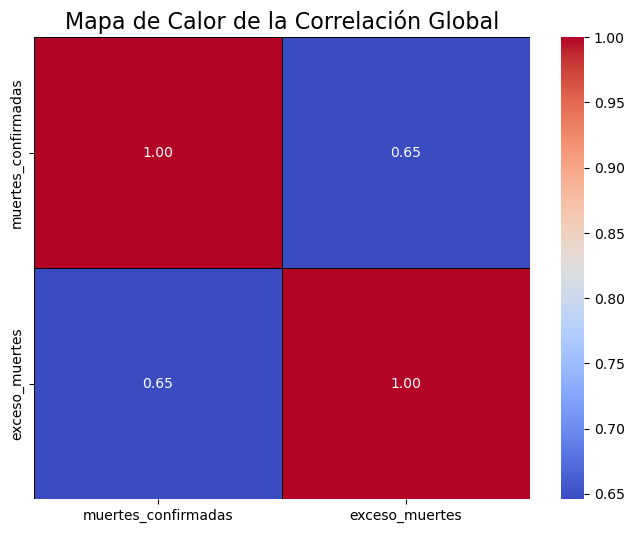

10:48:54.705 | INFO    | Task run 'calculate_and_plot_global_correlation-46b' - Finished in state Completed()

c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ASUS Vivobook\anaconda3\envs\BigDataPipelines\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\1798465293.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df.groupby('pais').apply(


10:48:55.010 | INFO    | Task run 'calculate_correlation_by_country-4d0' - 
--- Correlación por País (ejemplo de 5 valores más bajos y más altos) ---

10:48:55.013 | INFO    | Task run 'calculate_correlation_by_country-4d0' - Países con la correlación más baja:

10:48:55.017 | INFO    | Task run 'calculate_correlation_by_country-4d0' -                pais  correlacion
          Greenland    -0.883269
Antigua and Barbuda    -0.763221
             Bhutan    -0.749181
            Vanuatu    -0.384479
         Luxembourg     0.325364

10:48:55.019 | INFO    | Task run 'calculate_correlation_by_country-4d0' - 
Países con la correlación más alta:

10:48:55.022 | INFO    | Task run 'calculate_correlation_by_country-4d0' -                   pais  correlacion
                  Guam     0.998887
       North Macedonia     0.999142
               Georgia     0.999273
               Reunion     0.999383
Bosnia and Herzegovina     0.999386

10:48:55.028 | INFO    | Task run 'calculate_correlation_by_country-4d0' - Finished in state Completed()

10:48:55.065 | INFO    | Flow run 'sticky-llama' - Finished in state Completed()

In [22]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT
                "pais",
                "fecha",
                "muertes_confirmadas",
                "exceso_muertes"
            FROM {table_name}
            WHERE "muertes_confirmadas" IS NOT NULL AND "exceso_muertes" IS NOT NULL;
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def calculate_and_plot_global_correlation(df):
    """
    Calcula la correlación global y genera un mapa de calor.
    """
    logger = get_run_logger()
    if df is None or df.empty:
        logger.warning("No hay datos para calcular la correlación global.")
        return None

    # Agrupar por país y tomar el último valor acumulado
    df_final = df.groupby('pais').max(numeric_only=True).reset_index()

    # Calcular la matriz de correlación
    corr_matrix = df_final[['muertes_confirmadas', 'exceso_muertes']].corr()
    correlation_global = corr_matrix.loc['muertes_confirmadas', 'exceso_muertes']
    
    logger.info(f"\n--- Correlación Global ---")
    logger.info(f"El coeficiente de correlación de Pearson (Global) es: {correlation_global:.4f}")
    
    # Generar el mapa de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
    plt.title('Mapa de Calor de la Correlación Global', fontsize=16)
    plt.show()

    return correlation_global

@task
def calculate_correlation_by_country(df):
    logger = get_run_logger()
    if df is None or df.empty:
        logger.warning("No hay datos para calcular la correlación por país.")
        return None

    correlations = df.groupby('pais').apply(
        lambda x: x['muertes_confirmadas'].corr(x['exceso_muertes'])
    ).reset_index(name='correlacion')
    
    correlations.dropna(inplace=True)
    correlations.sort_values(by='correlacion', inplace=True)

    logger.info("\n--- Correlación por País (ejemplo de 5 valores más bajos y más altos) ---")
    logger.info("Países con la correlación más baja:")
    logger.info(correlations.head(5).to_string(index=False))
    
    logger.info("\nPaíses con la correlación más alta:")
    logger.info(correlations.tail(5).to_string(index=False))

    return correlations

@flow(name="Análisis de Correlación de Muertes")
def analyze_correlation_flow():
    df = extract_from_db(db_params)
    if df is not None:
        calculate_and_plot_global_correlation(df)
        calculate_correlation_by_country(df)

# Ejecutar el flow
analyze_correlation_flow()

### ¿Cuál es el tiempo de retraso entre los picos de muertes confirmadas y  exceso de muertes en los países más afectados?
Los datos indican que los países de la región de Europa del Este tienen el mayor exceso de mortalidad, con Lituania, Bulgaria y Rusia ocupando las tres posiciones mas altas.

**Alto Subregistro:** Países como Mónaco y Rusia muestran porcentajes de subregistro altos superando el 70%. Esto representa que por cada muerte confirmada, hubo muchas más que no se le atribuyeron de forma oficial a la pandemia.

**Caso Extremo:** El caso de Niue, cuenta con un porcentaje del 100% de subregistro. Esto podría deberse a una falta completa de reporte de muertes por COVID-19, una población muy pequeña, o un problema con los datos.

**Conclusión**

Los resultados revelan que en estos paises el sistema de reporte de muertes confirmadas fue deficiente, se podría deber a una falta de pruebas masivas, clasificación errónea de las muertes, o porque una saturación extrema de los sistemas de salud debido a la crisis sanitaria.



11:19:07.147 | INFO    | Flow run 'analytic-centipede' - Beginning flow run 'analytic-centipede' for flow 'excess-mortality-analysis-flow'

C:\Users\ASUS Vivobook\AppData\Local\Temp\ipykernel_24376\2742802548.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


11:19:07.206 | INFO    | Task run 'extract_from_db-2d3' - Finished in state Completed()

11:19:07.236 | INFO    | Task run 'analyze_excess_mortality-6a2' - 
--- Los 10 países con mayor exceso de mortalidad (por 100,000 habitantes) ---

11:19:07.242 | INFO    | Task run 'analyze_excess_mortality-6a2' -                            pais  exceso_muertes  muertes_confirmadas  diferencia  subregistro_pct
                      Lithuania            1096                  348         748        68.248175
                       Bulgaria            1094                  567         527        48.171846
                         Russia            1016                  277         739        72.736220
                         Serbia             922                  266         656        71.149675
                        Belarus             852                   78         774        90.845070
                North Macedonia             845                  542         303        35.857988
         Bosnia and Herzegovina             799                  511         288        36.045056
                         Monaco             790                  172         618        78.227848
                        Croatia             713                  480         233        32.678822
Bonaire Sint Eustatius and Saba             705                  143         562        79.716312

11:19:07.246 | INFO    | Task run 'analyze_excess_mortality-6a2' - 
--- País con el mayor subregistro de muertes ---

11:19:07.249 | INFO    | Task run 'analyze_excess_mortality-6a2' - El país con el mayor subregistro es Niue con un 100.00% de subregistro.

11:19:07.254 | INFO    | Task run 'analyze_excess_mortality-6a2' - Finished in state Completed()

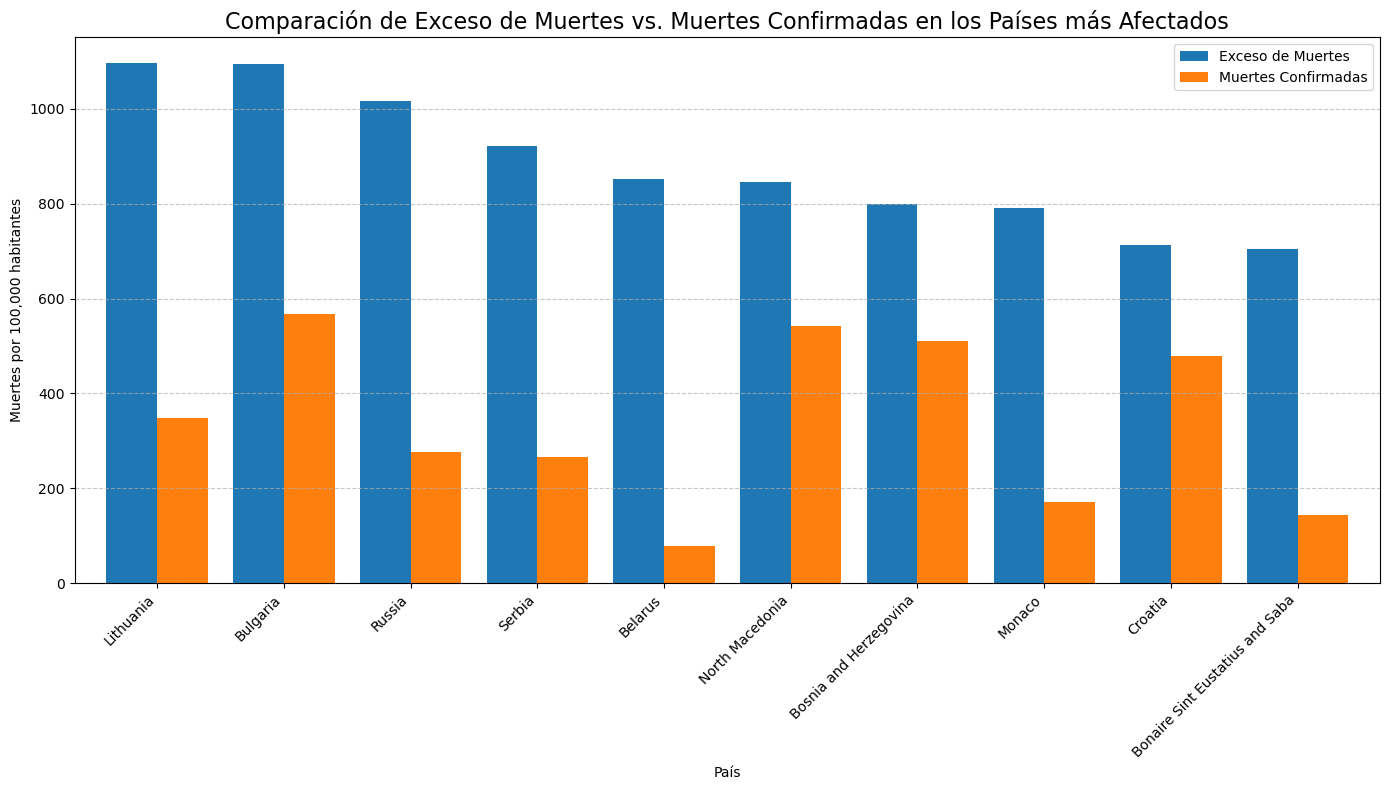

11:19:07.517 | INFO    | Task run 'plot_mortality_comparison-84a' - Finished in state Completed()

11:19:07.562 | INFO    | Flow run 'analytic-centipede' - Finished in state Completed()

In [30]:
from prefect import flow, task, get_run_logger

db_params = {
    'dbname': 'covid19-project',
    'user': 'psqluser',
    'password': 'psqlpass',
    'host': 'localhost',
    'port': '5433'
}

@task
def extract_from_db(db_params, table_name="muertes_covid19"):
    logger = get_run_logger()
    try:
        conn = psycopg2.connect(**db_params)
        query = f"""
            SELECT
                "pais",
                MAX("muertes_confirmadas") AS "muertes_confirmadas",
                MAX("exceso_muertes") AS "exceso_muertes"
            FROM {table_name}
            WHERE "muertes_confirmadas" IS NOT NULL AND "exceso_muertes" IS NOT NULL
            GROUP BY "pais";
        """
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    except Exception as e:
        logger.error(f"Error extrayendo datos de PostgreSQL: {e}")
        raise

@task
def analyze_excess_mortality(df, top_n=10):
    logger = get_run_logger()
    if df is None or df.empty:
        logger.warning("No hay datos para el análisis.")
        return None

    df_sorted = df.sort_values(by="exceso_muertes", ascending=False)

    df_sorted['diferencia'] = df_sorted['exceso_muertes'] - df_sorted['muertes_confirmadas']
    df_sorted['subregistro_pct'] = (df_sorted['diferencia'] / df_sorted['exceso_muertes']) * 100
    df_sorted.loc[df_sorted['subregistro_pct'] < 0, 'subregistro_pct'] = 0

    top_excess = df_sorted.head(top_n)
    
    logger.info(f"\n--- Los {top_n} países con mayor exceso de mortalidad (por 100,000 habitantes) ---")
    logger.info(top_excess[['pais', 'exceso_muertes', 'muertes_confirmadas', 'diferencia', 'subregistro_pct']].to_string(index=False))

    max_subregistro_pais = df_sorted.sort_values(by='subregistro_pct', ascending=False).iloc[0]
    logger.info(f"\n--- País con el mayor subregistro de muertes ---")
    logger.info(f"El país con el mayor subregistro es {max_subregistro_pais['pais']} con un {max_subregistro_pais['subregistro_pct']:.2f}% de subregistro.")
    
    return top_excess

@task
def plot_mortality_comparison(df_top_excess):
    if df_top_excess is None or df_top_excess.empty:
        return

    df_top_excess.set_index('pais', inplace=True)
    df_top_excess[['exceso_muertes', 'muertes_confirmadas']].plot(kind='bar', figsize=(14, 8), width=0.8)
    
    plt.title('Comparación de Exceso de Muertes vs. Muertes Confirmadas en los Países más Afectados', fontsize=16)
    plt.xlabel('País')
    plt.ylabel('Muertes por 100,000 habitantes')
    plt.xticks(rotation=45, ha='right')
    plt.legend(['Exceso de Muertes', 'Muertes Confirmadas'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

@flow
def excess_mortality_analysis_flow():
    df = extract_from_db(db_params)
    if df is not None:
        top_excess_df = analyze_excess_mortality(df)
        plot_mortality_comparison(top_excess_df)

# Ejecutar el flow
excess_mortality_analysis_flow()